In [1]:
### Packages and data 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import pandas as pd
import seaborn as sns

### Load transcript-to-gene mapping
dic_transcript_gene = {}
with open("/home/mouren/Data/revisions/specificity/list_transript_gene_id_gencodeV41_all_proteincoding.tsv") as file:
    for line in file:
        tx, gene = line.strip().split()[:2]
        dic_transcript_gene[tx] = gene.split(".")[0]

### EE
ee = []
with open("/home/mouren/Data/revisions/specificity/list_ee_id") as file:
    for line in file:  
        if dic_transcript_gene[line.strip().split()[0].strip().split("_")[0]] not in ee:
            ee.append(dic_transcript_gene[line.strip().split()[0].strip().split("_")[0]])

### Neg
neg = []
with open("/home/mouren/Data/revisions/specificity/list_neg_id") as file:
    for line in file:  
        if dic_transcript_gene[line.strip().split()[0].strip().split("_")[0]] not in neg:
            neg.append(dic_transcript_gene[line.strip().split()[0].strip().split("_")[0]])

### interactions
target = []
with open("/home/mouren/Data/revisions/specificity/robust_associations_exons_genes.txt") as file:
    for line in file:  
        if line.strip().split()[1] not in target:
            target.append(line.strip().split()[1])

In [2]:
# Uhlen data
df = pd.read_csv("/home/mouren/Data/gene_expr_tendency/uhlen2019_data1.csv", sep="\t", header=0)

df_res = pd.DataFrame(columns=["Dataset","Category"]) 

for gene in ee:
    filtered_row = df[df['ensg_id'] == gene]
    if filtered_row.empty:
        continue
    if filtered_row["specificity_category"].values[0] in ["Tissue enriched","Group enriched","Tissue enhanced"]:
        df_res.loc[len(df_res)] = ["cEEs\n(Host genes)",'Elevated expr.']
    else:
        df_res.loc[len(df_res)] = ["cEEs\n(Host genes)",filtered_row["specificity_category"].values[0]]

for gene in target:
    filtered_row = df[df['ensg_id'] == gene]
    if filtered_row.empty:
        continue
    if filtered_row["specificity_category"].values[0] in ["Tissue enriched","Group enriched","Tissue enhanced"]:
        df_res.loc[len(df_res)] = ["cEEs\n(Target genes)",'Elevated expr.']
    else:
        df_res.loc[len(df_res)] = ["cEEs\n(Target genes)",filtered_row["specificity_category"].values[0]]

for gene in neg:
    filtered_row = df[df['ensg_id'] == gene]
    if filtered_row.empty:
        continue
    if filtered_row["specificity_category"].values[0] in ["Tissue enriched","Group enriched","Tissue enhanced"]:
        df_res.loc[len(df_res)] = ["Ctrl-",'Elevated expr.']
    else:
        df_res.loc[len(df_res)] = ["Ctrl-",filtered_row["specificity_category"].values[0]]

values = df['specificity_category'].dropna().tolist()
for i in values:
    if i in ["Tissue enriched","Group enriched","Tissue enhanced"]:
        df_res.loc[len(df_res)] = ["All",'Elevated expr.']
    else:
        df_res.loc[len(df_res)] = ["All",i]

In [3]:
# Proportion df
count_df_res = df_res.groupby(['Dataset', 'Category']).size().unstack(fill_value=0)

from scipy.stats import chi2_contingency
import numpy as np

# Run chi-squared test
chi2, pval, dof, expected = chi2_contingency(count_df_res)

# Compute Cramér’s V for effect size
def cramers_v(table):
    chi2_val, _, _, _ = chi2_contingency(table)
    n = table.sum().sum()
    phi2 = chi2_val / n
    r, k = table.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

v = cramers_v(count_df_res)

# Print results
print(f"Chi-squared p-value: {pval:.3g}")
print(f"Cramér's V: {v:.3f}")


df_res_proportion = count_df_res.div(count_df_res.sum(axis=1), axis=0)
df_res_proportion = df_res_proportion.reset_index()

Chi-squared p-value: 2e-66
Cramér's V: 0.067


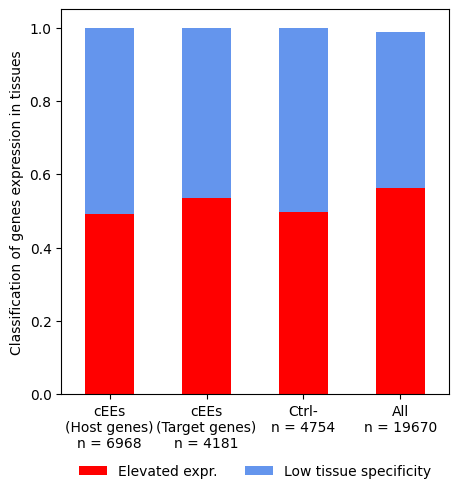

In [6]:
# Plot
category_order = ['Elevated expr.', 'Low tissue specificity']

# --- Compute N for each dataset ---
# Total counts per Dataset (from the original count table)
N_per_dataset = count_df_res.sum(axis=1)

# Make sure ordering matches the plot order
dataset_order = ["cEEs\n(Host genes)", "cEEs\n(Target genes)", "Ctrl-", "All"]
N_per_dataset = N_per_dataset.reindex(dataset_order)

### Host
# Reorder columns
plot_df = df_res_proportion.set_index('Dataset')[category_order]
plot_df = plot_df.reindex(["cEEs\n(Host genes)","cEEs\n(Target genes)","Ctrl-","All"])

plot_df.plot(kind='bar', stacked=True, color=["red","cornflowerblue"], figsize=(5, 5))

# --- Build new x tick labels with N ---
new_labels = [
    f"{ds}\nn = {N_per_dataset.loc[ds]}"
    for ds in dataset_order
]

plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=0)

plt.ylabel('Classification of genes expression in tissues')
plt.xlabel(None)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(category_order),
    frameon=False
)

#plt.text(0.5, 1.05, f"P={pval:.1e};V={v:.2f}", ha='center', va='bottom', fontsize=9, transform=plt.gca().transAxes)

"""
"The distribution of tissue specificity categories differs significantly across datasets (Chi-squared test, p = 2e-66). 
However, the effect size is small (Cramér’s V = 0.067), indicating that the difference, while statistically detectable, is modest in magnitude."
"""

plt.savefig("/home/mouren/Images/revisions/specificity_test/rev_1_pt4_uhlen_all.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/revisions/specificity_test/rev_1_pt4_uhlen_all.png", format="png", bbox_inches="tight", dpi=450)

plt.show()